# Groudon Detector

### Project Overview

In this project, we will be detecting anomalies in real data from the Apollo missions and the Mars InSight Lander to identify seismic quakes within the noise using LSTM Autoencoders using Keras with tensorflow backend.

## Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 16, 6 # set figsize for all images

np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.17.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

To get you started on the data, we present to you a training set containing the following:

1. A catalog of quakes identified in the data
2. Seismic data collected by the Apollo (one day segments) or InSight (one hour segments) missions in miniseed and CSV format.
3. Plots of the trace and spectrogram for each day a quake has been identified.

Using these tools, your task is to come up with an algorithm to identify these signals (using the catalog as a benchmark) and then
apply your algorithm to the seismic data in the "test" folder (Apollo 12, 15, and 16 for the Moon and other InSight events for Mars).

Each trace included in the test folder has a quake in it, there are no empty traces.

This main folder also has a Jupyter notebook that will help you get started on the data.

** IMPORTANT **
Please make sure that your output catalog has at least the following headers:
filename
time_abs(%Y-%m-%dT%H:%M:%S.%f) or time_rel(sec)

If not, your output catalog may not be scored!!


[Data Source](https://drive.google.com/drive/folders/1RcArkpfBtYDVa07kB2sFb5-xAd8qrGKr?usp=sharing)

In [ ]:
!pip3 install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [ ]:
!pip3 show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
!pip3 install tensorflow==2.17.0

In [ ]:
# function for detecting ouliers based on IQR
def findOutliers(x,column):
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    iqr = q3 - q1
    y = x[(x[column] > (q3 + 1.5*iqr)) | (x[column] < (q1 - 1.5*iqr))]
    return len(y), y

In [ ]:
# function for changing ouliers based on IQR
def changeOutliers(x,column):
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)

    iqr = q3 - q1

    # Set up Min, Max for substitution for outliers
    Min = q1 - 1.5*iqr
    Max = q3 + 1.5*iqr

    # Substitute to Max for the data that is bigger than Max and substitute to Min for the data that is smaller than Min
    x.loc[(x[column] > Max), column] = Max
    x.loc[(x[column] > Min), column] = Min

    return(x)

In [ ]:
fileList = ['XB.ELYSE.02.BHV.2022-01-02HR04_evid0006', 'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005']
csv_directory = '/content/drive/MyDrive/trainingData/'

# Calculate the number of ouliers
filename_0 = fileList[0]
filepath = os.path.join(csv_directory + filename_0 + ".csv")
df_0 = pd.read_csv(filepath)
df_0 = df_0[['time(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(c/s)']]

filename_1 = fileList[1]
filepath = os.path.join(csv_directory + filename_1 + ".csv")
df_1 = pd.read_csv(filepath)
df_1 = df_1[['time(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(c/s)']]

print("velocity(c/s) IQR outliers: ", findOutliers(df_0, 'velocity(c/s)'))
print("velocity(c/s) IQR outliers: ", findOutliers(df_1, 'velocity(c/s)'))

velocity(c/s) IQR outliers:  (3510,        time(%Y-%m-%dT%H:%M:%S.%f)  velocity(c/s)
4972   2022-01-02T04:04:08.625000     417.393860
5485   2022-01-02T04:04:34.275000    -413.031372
5565   2022-01-02T04:04:38.275000    -423.666870
5593   2022-01-02T04:04:39.675000     555.510742
5595   2022-01-02T04:04:39.775000    -426.405212
...                           ...            ...
57423  2022-01-02T04:47:51.175000    -407.719604
57478  2022-01-02T04:47:53.925000     417.593506
58330  2022-01-02T04:48:36.525000    -458.574646
59096  2022-01-02T04:49:14.825000    -424.359680
70453  2022-01-02T04:58:42.675000     413.271912

[3510 rows x 2 columns])
velocity(c/s) IQR outliers:  (4703,        time(%Y-%m-%dT%H:%M:%S.%f)  velocity(c/s)
8546   2022-02-03T08:07:07.309000    -373.686035
8548   2022-02-03T08:07:07.409000     221.286682
8554   2022-02-03T08:07:07.709000     247.204865
8555   2022-02-03T08:07:07.759000     254.191223
8556   2022-02-03T08:07:07.809000     259.177582
...                 

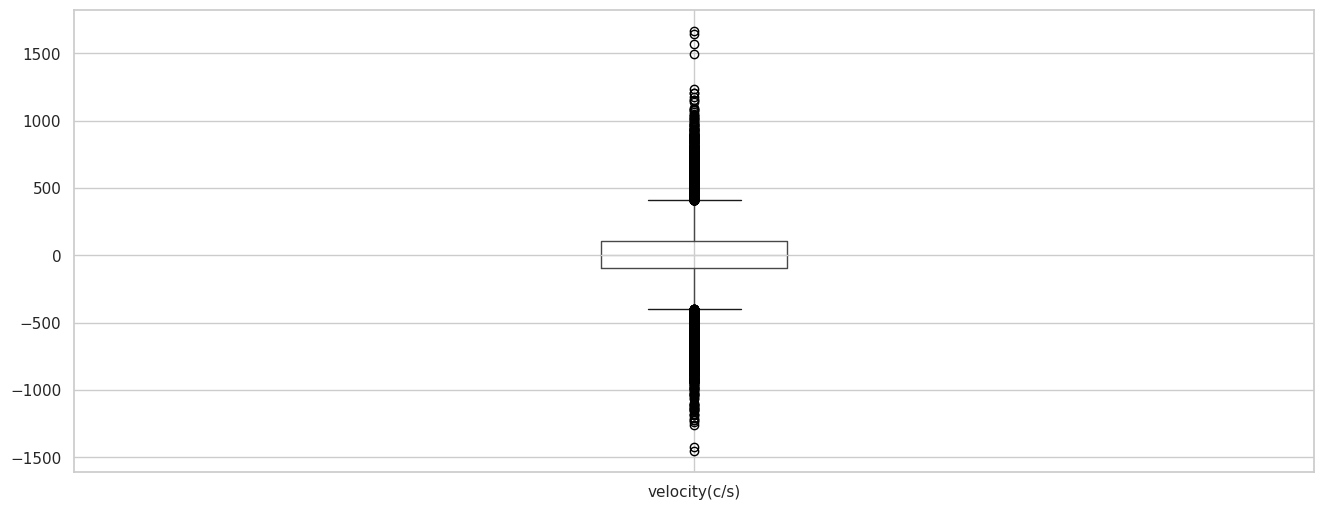

In [ ]:
plt.figure()

# boxplot
df_0[['velocity(c/s)']].boxplot()
plt.show()

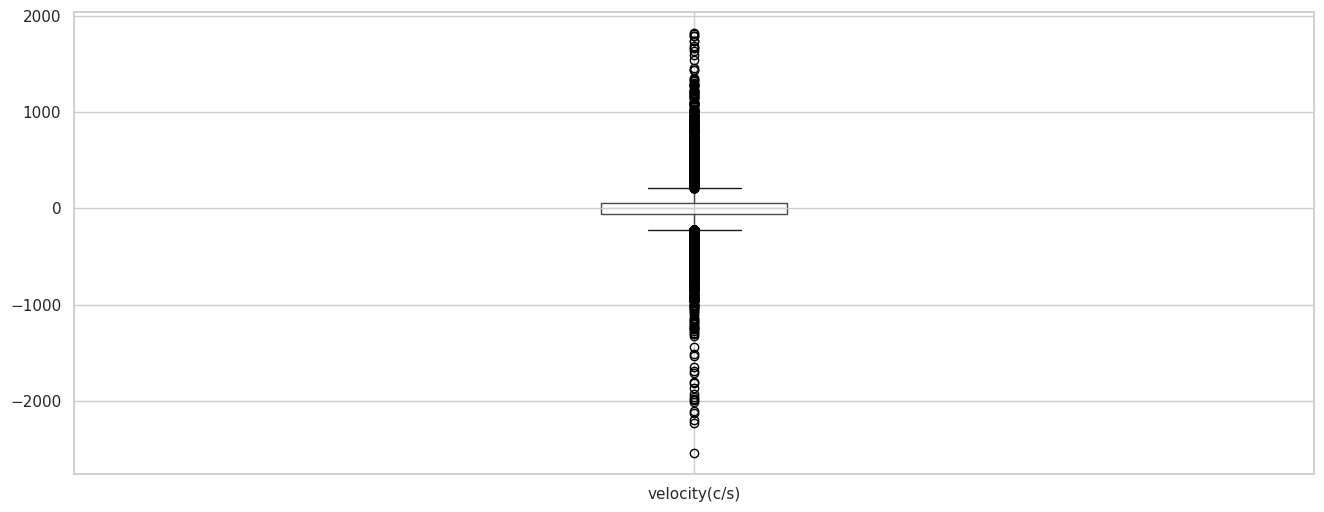

In [ ]:
plt.figure()

# boxplot
df_1[['velocity(c/s)']].boxplot()
plt.show()

In [ ]:
# Calculate the number of outliers
resCount_0, resDf_0 = findOutliers(df_0,'velocity(c/s)')
print("Price IQR Outliers: ", resCount_0)

resCount_1, resDf_1 = findOutliers(df_1,'velocity(c/s)')
print("Price IQR Outliers: ", resCount_1)

Price IQR Outliers:  3510
Price IQR Outliers:  4703


In [ ]:
q1_0 = df_0['velocity(c/s)'].quantile(0.25)
q3_0 = df_0['velocity(c/s)'].quantile(0.75)

iqr_0 = q3_0 - q1_0

# Set up Min, Max for substitution for outliers
Min_0 = q1_0 - 1.5 * iqr_0
Max_0 = q3_0 + 1.5 * iqr_0

q1_1 = df_1['velocity(c/s)'].quantile(0.25)
q3_1 = df_1['velocity(c/s)'].quantile(0.75)

iqr_1 = q3_1 - q1_1

# Set up Min, Max for substitution for outliers
Min_1 = q1_1 - 1.5 * iqr_1
Max_1 = q3_1 + 1.5 * iqr_1

print(q1_0, q3_0, iqr_0, Min_0, Max_0)
print(q1_1, q3_1, iqr_1, Min_1, Max_1)

-97.34070205688478 105.1653480529785 202.50605010986328 -401.0997772216797 408.92442321777344
-58.614696502685554 50.723931312561035 109.33862781524658 -222.62263822555542 214.7318730354309


In [ ]:
temp_0 = df_0
temp_1 = df_1

# Replace anomalies in 'velocity(c/s)' using the calculated bounds
temp_0['velocity(c/s)'] = temp_0['velocity(c/s)'].clip(lower = Min_0, upper = Max_0)
temp_1['velocity(c/s)'] = temp_1['velocity(c/s)'].clip(lower = Min_1, upper = Max_1)


temp_0

time(%Y-%m-%dT%H:%M:%S.%f)  velocity(c/s)
0      2022-01-02T04:00:00.025000       0.000000
1      2022-01-02T04:00:00.075000       0.000503
2      2022-01-02T04:00:00.125000       0.003635
3      2022-01-02T04:00:00.175000       0.010198
4      2022-01-02T04:00:00.225000       0.028214
...                           ...            ...
71995  2022-01-02T04:59:59.775000       0.010700
71996  2022-01-02T04:59:59.825000       0.006193
71997  2022-01-02T04:59:59.875000       0.002047
71998  2022-01-02T04:59:59.925000       0.000555
71999  2022-01-02T04:59:59.975000       0.000000

[72000 rows x 2 columns]

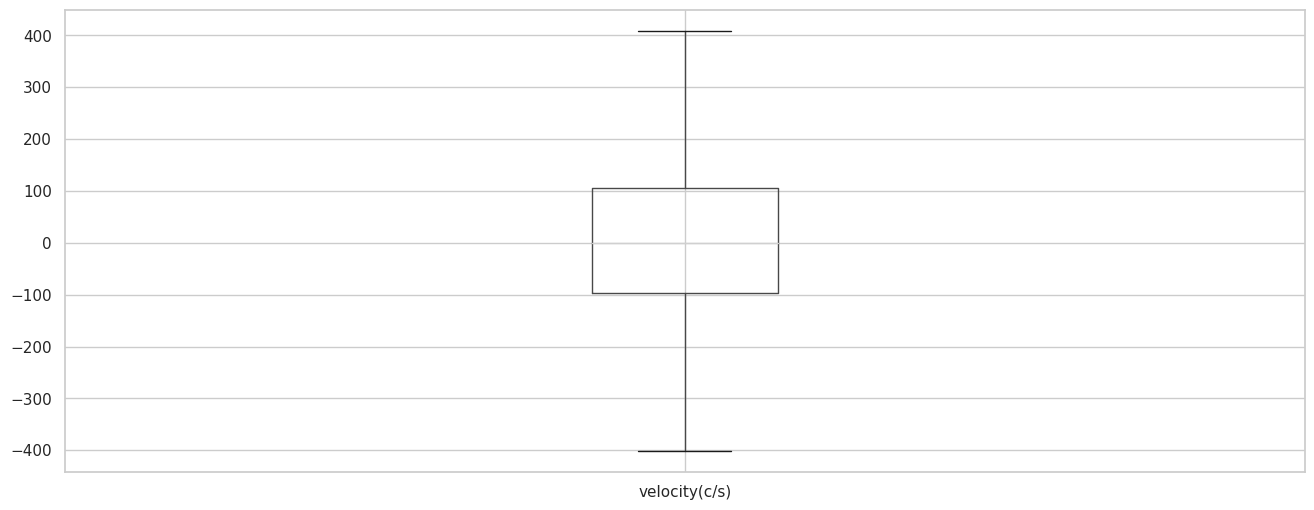

In [ ]:
plt.figure()

# boxplot
temp_0[['velocity(c/s)']].boxplot()
plt.show()

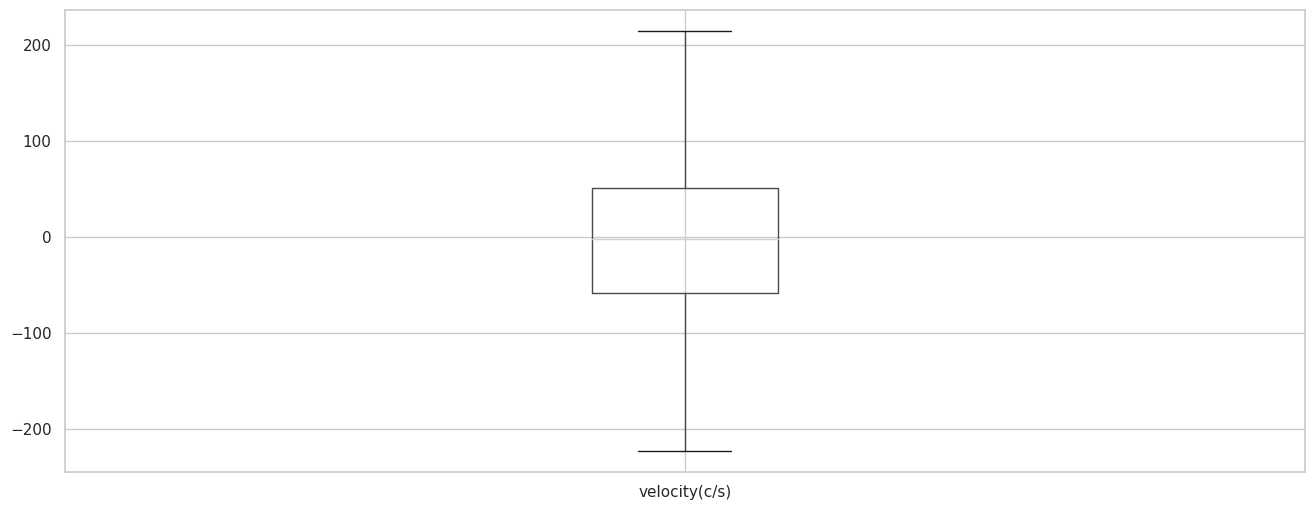

In [ ]:
plt.figure()

# boxplot
temp_1[['velocity(c/s)']].boxplot()
plt.show()

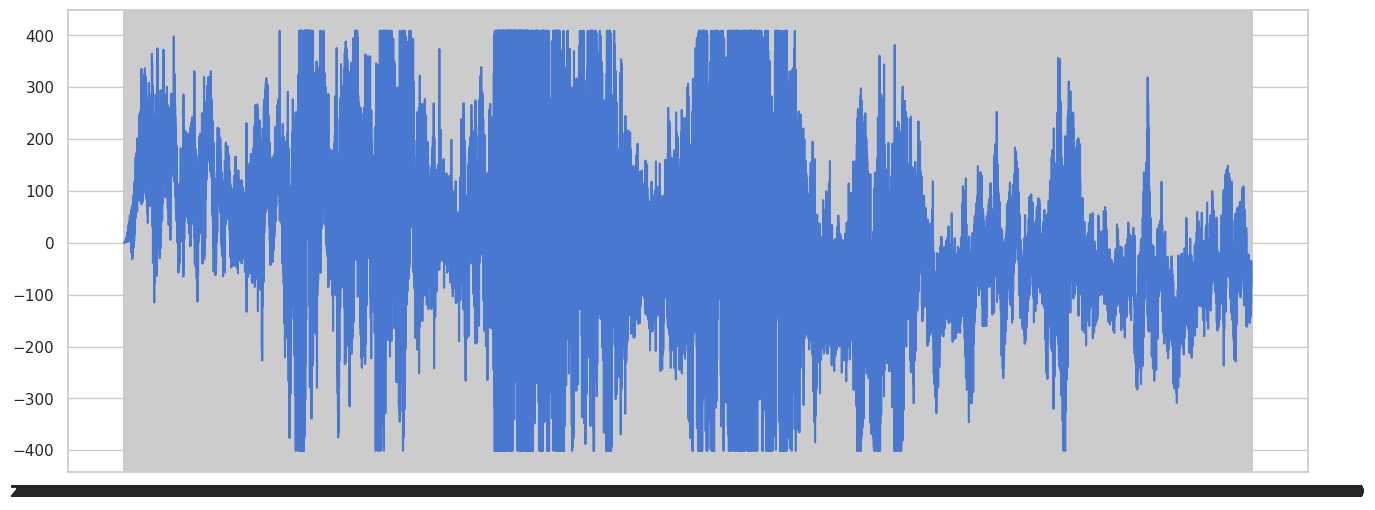

In [ ]:
import matplotlib.pyplot as plt

# Read in time steps and velocities
csv_times = temp_0.iloc[:36000,0]
csv_data = temp_0.iloc[:36000,1]

# Plot the trace!
plt.plot(csv_times, csv_data)
plt.show()

In [ ]:
m_df = pd.concat([temp_0, temp_1], ignore_index=True)

m_df

time(%Y-%m-%dT%H:%M:%S.%f)  velocity(c/s)
0       2022-01-02T04:00:00.025000       0.000000
1       2022-01-02T04:00:00.075000       0.000503
2       2022-01-02T04:00:00.125000       0.003635
3       2022-01-02T04:00:00.175000       0.010198
4       2022-01-02T04:00:00.225000       0.028214
...                            ...            ...
143995  2022-02-03T08:59:59.759000      -0.003213
143996  2022-02-03T08:59:59.809000      -0.003827
143997  2022-02-03T08:59:59.859000      -0.002980
143998  2022-02-03T08:59:59.909000      -0.000506
143999  2022-02-03T08:59:59.959000       0.000000

[144000 rows x 2 columns]

In [ ]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from obspy import read
import os


def trainModel():

  scalar = StandardScaler()

  scalar = scalar.fit(m_df[['velocity(c/s)']]) # scaler model

  model = Sequential()

  counter = 0

  # convert to .mseed file reading code
  for i in range(2):
    fileList = ['XB.ELYSE.02.BHV.2022-01-02HR04_evid0006', 'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005']
    train_filename = fileList[i]
    csv_directory = '/content/drive/MyDrive/trainingData/'

    filepath = os.path.join(csv_directory + train_filename + ".csv")

    # Use pandas to read the CSV file
    temp_df = pd.read_csv(filepath)

    # Assuming your CSV has columns named 'time' and 'velocity'
    # Rename columns to match the desired format
    train = temp_df.rename(columns={'time': 'time(%Y-%m-%dT%H:%M:%S.%f)', 'velocity': 'velocity(c/s)'})

    train = train[['time(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(c/s)']]

    train['velocity(c/s)'] = scalar.transform(train[['velocity(c/s)']])

    time_steps = 30

    X_train, y_train = create_sequences(train[['velocity(c/s)']], train['velocity(c/s)'], time_steps)


    timesteps = X_train.shape[1]
    num_features = X_train.shape[2]

    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(RepeatVector(timesteps)) # Repeats the input n times.
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(num_features))) # apply a layer to every temporal slice of an input.

    model.compile(loss='mae',optimizer='adam')

    early_stop = EarlyStopping(monitor='val_loss',patience=3,mode='min') # if the monitored metric does not change wrt to the mode applied for 3 epochs, stop training
    history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[early_stop], shuffle=False)

    model.save('/content/drive/MyDrive/model/seismic_detection_model_'+ str(counter) +'.h5')

    counter += 1
    currentindex = counter  * 6

    for layer in model.layers[:currentindex]:
        layer.trainable = False

  model.save('/content/drive/MyDrive/model/seismic_detection_model.h5')
  model.summary()

  return history, scalar

In [ ]:
history, scalar = trainModel()

Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.7368 - val_loss: 0.4879
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7340 - val_loss: 0.4325
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7302 - val_loss: 0.4022
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7270 - val_loss: 0.3487
Epoch 5/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7241 - val_loss: 0.3606
Epoch 6/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7221 - val_loss: 0.3299
Epoch 7/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7217 - val_loss: 0.3310
Epoch 8/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7218 - val_loss: 0.3338
Epoch 9/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7200 - val_loss: 0.3467


Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.5859 - val_loss: 0.4024
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5780 - val_loss: 0.3990
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5772 - val_loss: 0.3975
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5775 - val_loss: 0.3963
Epoch 5/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5772 - val_loss: 0.3950
Epoch 6/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5771 - val_loss: 0.3934
Epoch 7/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5770 - val_loss: 0.3903
Epoch 8/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5768 - val_loss: 0.3882
Epoch 9/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5768 - val_loss: 0.3876
Epoch 10/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5770 - val_loss: 0.3848
Epoch 11/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5768 - val_loss: 0.3860
Epoch 12/100
507/507 ━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 793,094 (3.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 396,546 (1.51 MB)

 Optimizer params: 396,548 (1.51 MB)

In [ ]:
print(history.history)

{'loss': [0.5323649644851685, 0.5275757312774658, 0.526680052280426, 0.5267276167869568, 0.5266016721725464, 0.5262808799743652, 0.5261071920394897, 0.5262082815170288, 0.5260455012321472, 0.5260216593742371, 0.5261113047599792, 0.5259235501289368, 0.5258562564849854, 0.5259453058242798, 0.5255908370018005, 0.5254580974578857, 0.5258873701095581, 0.5259149074554443, 0.526170551776886, 0.5261953473091125, 0.526015043258667, 0.525913417339325, 0.5263051390647888, 0.5261679291725159, 0.5265576839447021, 0.5267227292060852, 0.526878833770752, 0.5270159840583801, 0.5267142653465271, 0.5266897082328796, 0.5268989205360413, 0.5270538330078125, 0.5269386768341064], 'val_loss': [0.4024105668067932, 0.3989807367324829, 0.397472620010376, 0.39628487825393677, 0.3949801027774811, 0.393407940864563, 0.39029228687286377, 0.38819006085395813, 0.38762998580932617, 0.384776771068573, 0.3859582841396332, 0.382183313369751, 0.3808973431587219, 0.37908121943473816, 0.3809199631214142, 0.37909361720085144,

In [ ]:
print(scalar)

StandardScaler()


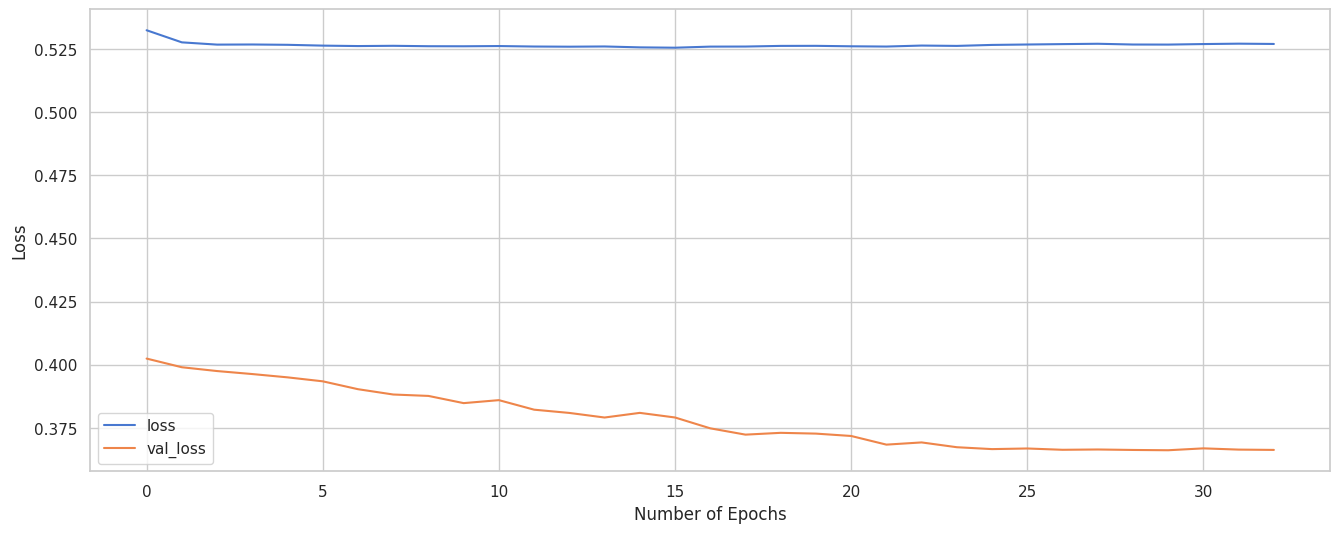

In [ ]:
err = pd.DataFrame(history.history)
err.plot()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss');

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model

from keras.src.legacy.saving import legacy_h5_format

model = legacy_h5_format.load_model_from_hdf5("/content/drive/MyDrive/model/STD_IQR/seismic_detection_model.h5", custom_objects={'mae': 'mae'})


#history = tf.keras.models.load_model('/content/anomaly_model.h5')
print(model)
print(model.summary())

<Sequential name=sequential, built=True>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,548 (1.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 396,546 (1.51 MB)

 Optimizer params: 2 (12.00 B)

None


In [ ]:
history

In [ ]:
train_mae_loss_final = pd.DataFrame(columns=['Error'])

for i in range(2):
  fileList = ['XB.ELYSE.02.BHV.2022-01-02HR04_evid0006', 'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005']
  train_filename = fileList[i]
  csv_directory = '/content/drive/MyDrive/trainingData/'

  filepath = os.path.join(csv_directory + train_filename + ".csv")

  # Use pandas to read the CSV file
  temp_df = pd.read_csv(filepath)

  # Assuming your CSV has columns named 'time' and 'velocity'
  # Rename columns to match the desired format
  train = temp_df.rename(columns={'time': 'time(%Y-%m-%dT%H:%M:%S.%f)', 'velocity': 'velocity(c/s)'})

  train = train[['time(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(c/s)']]

  train['velocity(c/s)'] = scalar.transform(train[['velocity(c/s)']])

  time_steps = 30

  X_train, y_train = create_sequences(train[['velocity(c/s)']], train['velocity(c/s)'], time_steps)

  # Calculating the mae for training data
  X_train_pred = model.predict(X_train)
  train_mae_loss_final = pd.concat([train_mae_loss_final, pd.DataFrame(np.mean(np.abs(X_train_pred - X_train),axis=1),columns=['Error'])])

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


In [ ]:
train_mae_loss_final

Error
0      0.060270
1      0.060151
2      0.060037
3      0.059839
4      0.059656
...         ...
71965  0.060094
71966  0.060166
71967  0.060418
71968  0.060756
71969  0.060786

[143940 rows x 1 columns]

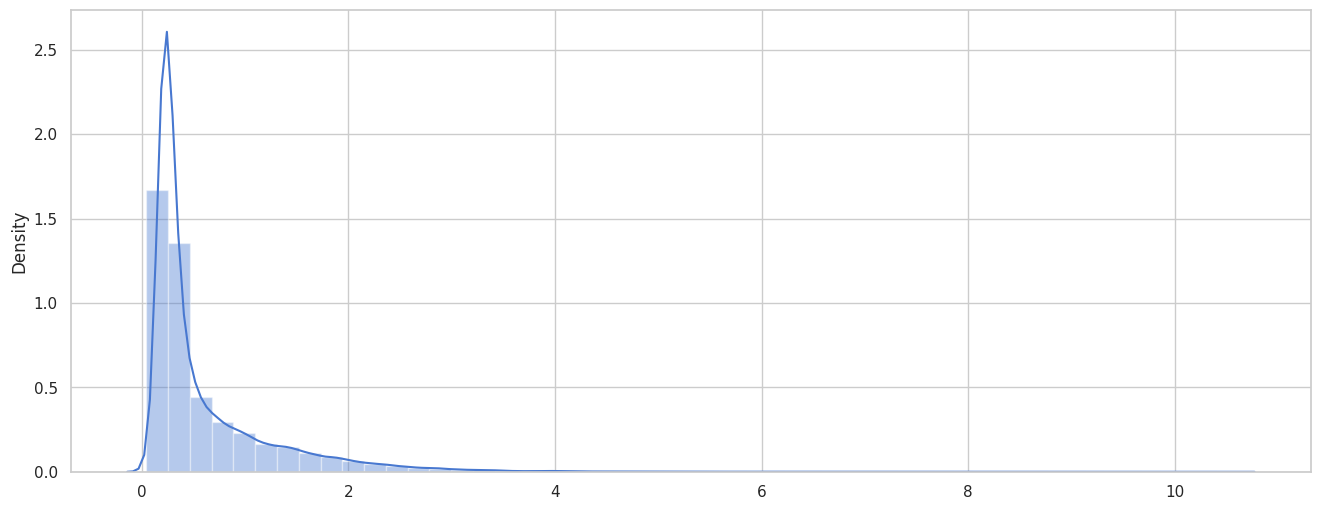

In [ ]:
sns.distplot(train_mae_loss_final,bins=50,kde=True); # Plot histogram of traning losses

In [ ]:
filtered = train_mae_loss_final[train_mae_loss_final['Error'] > 3.5]

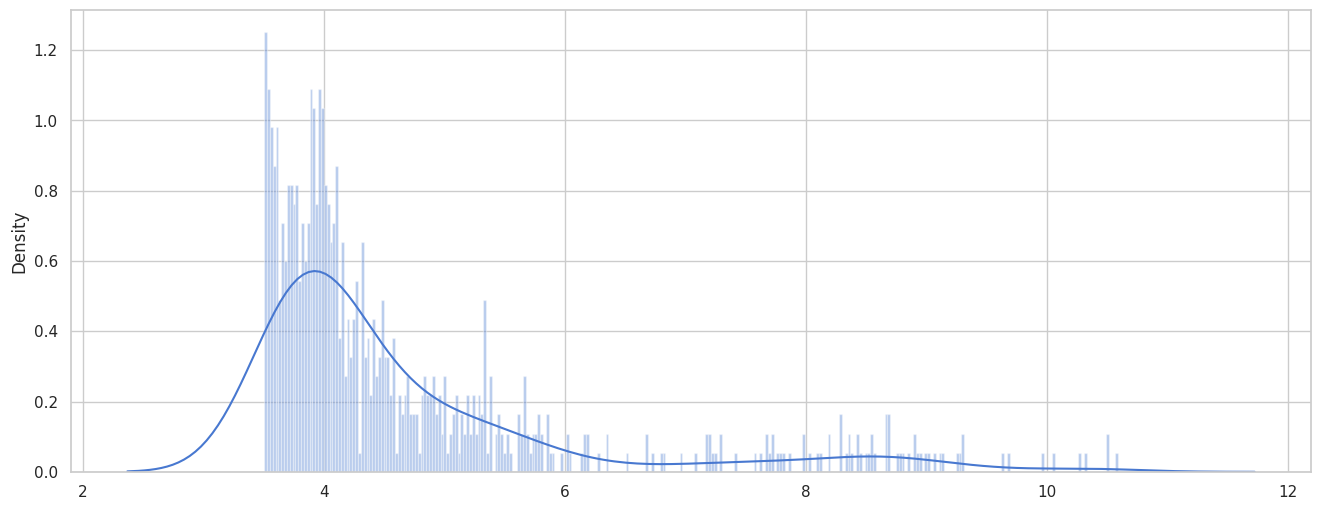

In [ ]:
sns.distplot(filtered,bins=300,kde=True); # Plot histogram of traning losses

In [ ]:
testDf = pd.DataFrame(train_mae_loss_final)
testDf.sort_values(by='Error', ascending=False)

Error
24018   3.836885
24017   3.823914
24015   3.802089
24014   3.765096
24016   3.745208
...          ...
419347  0.000241
412478  0.000237
412475  0.000214
412476  0.000201
412477  0.000188

[572385 rows x 1 columns]

In [ ]:
threshold = 6

if we notice a error > threshold, we will say that it is an anamoly

In [ ]:
# test dataset
test = pd.read_csv("/content/drive/MyDrive/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv")

test['velocity(c/s)'] = scalar.transform(test[['velocity(c/s)']])

time_steps = 30

X_test, y_test = create_sequences(test[['velocity(c/s)']],test['velocity(c/s)'],time_steps)

X_test
y_test

array([0.00666524, 0.00626324, 0.0080366 , ..., 0.01111558, 0.01111022,
       0.0111083 ])

In [ ]:
# Calculate mae for test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test),axis=1)

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


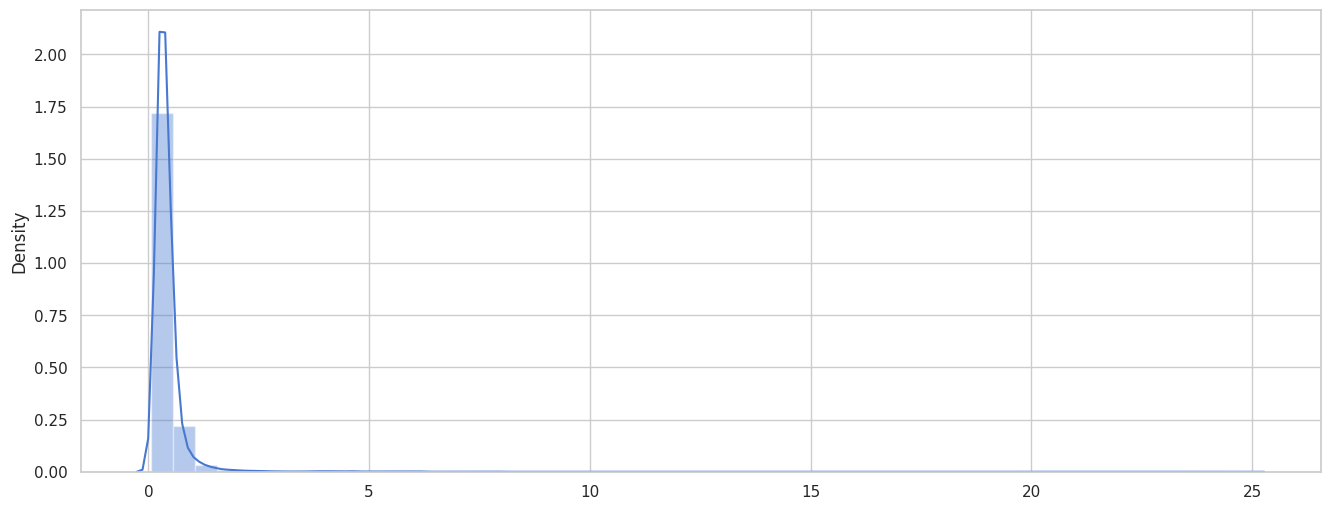

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True); # Plot histogram of test losses

## Detect Anomalies in the Test Data

In [ ]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['velocity(c/s)'] = test[time_steps:]['velocity(c/s)']

In [ ]:
test_score_df.head()

time(%Y-%m-%dT%H:%M:%S.%f)  rel_time(sec)  velocity(c/s)      loss  \
30  2019-05-23T02:00:01.532000           1.50       0.006665  0.062726   
31  2019-05-23T02:00:01.582000           1.55       0.006263  0.062837   
32  2019-05-23T02:00:01.632000           1.60       0.008037  0.062909   
33  2019-05-23T02:00:01.682000           1.65       0.009452  0.062914   
34  2019-05-23T02:00:01.732000           1.70       0.005323  0.062896   

    threshold  anomaly  
30          6    False  
31          6    False  
32          6    False  
33          6    False  
34          6    False

In [ ]:
test_score_df.tail()

time(%Y-%m-%dT%H:%M:%S.%f)  rel_time(sec)  velocity(c/s)      loss  \
71995  2019-05-23T02:59:59.782000        3599.75       0.011113  0.062434   
71996  2019-05-23T02:59:59.832000        3599.80       0.011111  0.062504   
71997  2019-05-23T02:59:59.882000        3599.85       0.011116  0.062541   
71998  2019-05-23T02:59:59.932000        3599.90       0.011110  0.062523   
71999  2019-05-23T02:59:59.982000        3599.95       0.011108  0.062441   

       threshold  anomaly  
71995          6    False  
71996          6    False  
71997          6    False  
71998          6    False  
71999          6    False

In [ ]:
test_score_df.to_csv('/content/drive/MyDrive/model/output.csv', index = False)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:]['time(%Y-%m-%dT%H:%M:%S.%f)'],y=test_score_df['loss'],mode='lines',name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:]['time(%Y-%m-%dT%H:%M:%S.%f)'],y=test_score_df['threshold'],mode='lines',name='Threshold'))
fig.update_layout(xaxis_title='Time',yaxis_title='Loss',showlegend=True)
fig.show()

In [ ]:
anomalies = test_score_df[test_score_df['anomaly']==True]
anomalies

time(%Y-%m-%dT%H:%M:%S.%f)  rel_time(sec)  velocity(c/s)      loss  \
27979  2019-05-23T02:23:18.982000        1398.95       7.356124  6.077499   
27980  2019-05-23T02:23:19.032000        1399.00       7.526036  6.162809   
27981  2019-05-23T02:23:19.082000        1399.05       7.843666  6.252794   
27982  2019-05-23T02:23:19.132000        1399.10       7.496563  6.369432   
27983  2019-05-23T02:23:19.182000        1399.15       8.006228  6.469257   
...                           ...            ...            ...       ...   
54613  2019-05-23T02:45:30.682000        2730.65       6.302615  6.183712   
54614  2019-05-23T02:45:30.732000        2730.70       6.021985  6.157246   
54615  2019-05-23T02:45:30.782000        2730.75       5.497619  6.114783   
54616  2019-05-23T02:45:30.832000        2730.80       5.962969  6.061884   
54617  2019-05-23T02:45:30.882000        2730.85       5.955618  6.021114   

       threshold  anomaly  
27979          6     True  
27980          6     True  
27981          6     True  
27982          6     True  
27983          6     True  
...          ...      ...  
54613          6     True  
54614          6     True  
54615          6     True  
54616          6     True  
54617          6     True  

[258 rows x 6 columns]

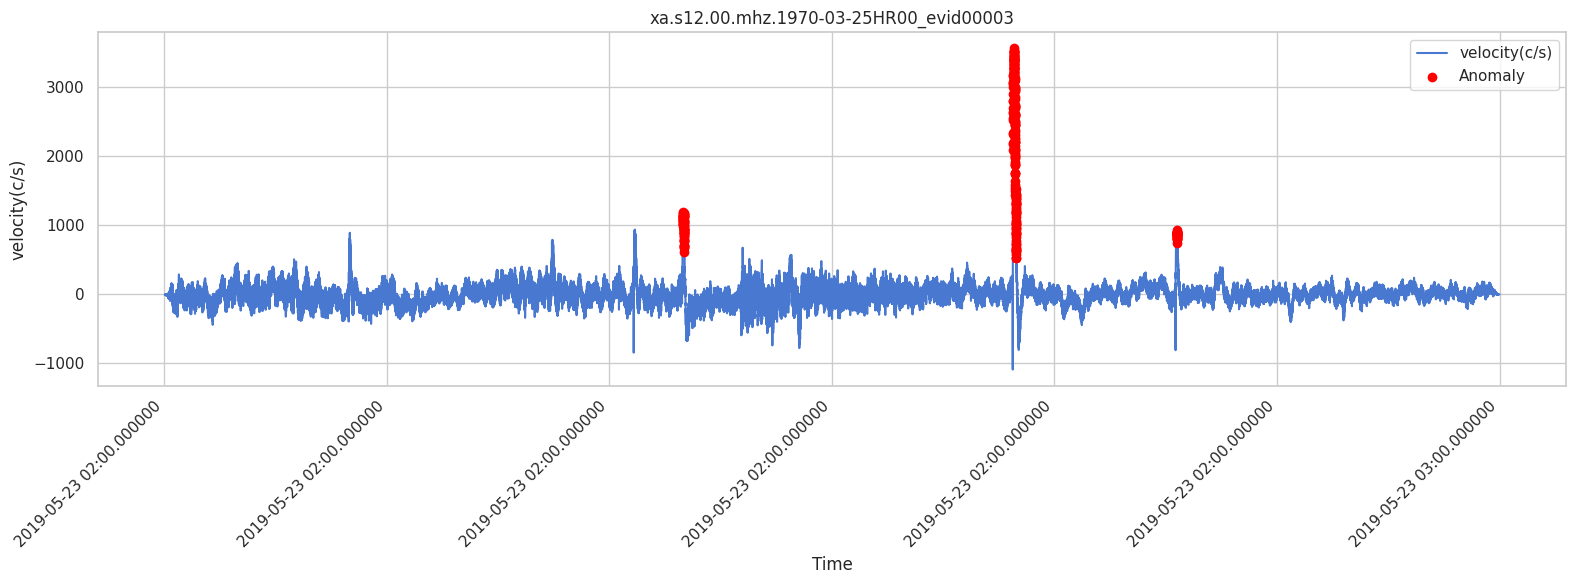

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert x data to datetime objects
x1 = pd.to_datetime(test[time_steps:]['time(%Y-%m-%dT%H:%M:%S.%f)'], format='%Y-%m-%dT%H:%M:%S.%f')
x2 = pd.to_datetime(anomalies['time(%Y-%m-%dT%H:%M:%S.%f)'], format='%Y-%m-%dT%H:%M:%S.%f')

# Extract y data
y1 = scalar.inverse_transform(test[time_steps:][['velocity(c/s)']])
y2 = scalar.inverse_transform(anomalies[['velocity(c/s)']])

# Create figure and axis
fig, ax = plt.subplots()

# Plot the first trace as a line
ax.plot(x1, y1, label='velocity(c/s)', zorder=1)

# Plot the second trace as markers
ax.scatter(x2, y2, color='red', label='Anomaly', zorder=2)

# Format the x-axis for dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%S.%f'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate date labels if necessary
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('velocity(c/s)')
ax.set_title('xa.s12.00.mhz.1970-03-25HR00_evid00003')

# Show legend
ax.legend()

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
import os
from obspy import read
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler

for i in range(9):

  scalar = StandardScaler()

  scalar = scalar.fit(m_df[['velocity(c/s)']]) # scaler model

  fileList = ['XB.ELYSE.02.BHV.2019-05-23HR02_evid0041', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033',
              'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034', 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032',
              'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017', 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011',
              'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007', 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002',
              'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001'
             ]
  test_filename = fileList[i]
  csv_directory = '/content/drive/MyDrive/test/data/'

  filepath = os.path.join(csv_directory + test_filename + ".csv")

  # test dataset
  test = pd.read_csv(filepath)

  test['velocity(c/s)'] = scalar.transform(test[['velocity(c/s)']])

  time_steps = 30

  X_test, y_test = create_sequences(test[['velocity(c/s)']],test['velocity(c/s)'],time_steps)

  # Calculate mae for test data
  X_test_pred = model.predict(X_test)
  test_mae_loss = np.mean(np.abs(X_test_pred - X_test),axis=1)

  test_score_df = pd.DataFrame(test[time_steps:])
  test_score_df['loss'] = test_mae_loss
  test_score_df['threshold'] = threshold
  test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
  test_score_df['velocity(c/s)'] = test[time_steps:]['velocity(c/s)']

  test_score_df.to_csv('/content/drive/MyDrive/model/output_' + test_filename + '.csv', index = False)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=test[time_steps:]['time(%Y-%m-%dT%H:%M:%S.%f)'],y=test_score_df['loss'],mode='lines',name='Test Loss'))
  fig.add_trace(go.Scatter(x=test[time_steps:]['time(%Y-%m-%dT%H:%M:%S.%f)'],y=test_score_df['threshold'],mode='lines',name='Threshold'))
  fig.update_layout(xaxis_title='Time',yaxis_title='Loss',showlegend=True)
  fig.show()

  anomalies = test_score_df[test_score_df['anomaly']==True]



  # Convert x data to datetime objects
  x1 = pd.to_datetime(test[time_steps:]['time(%Y-%m-%dT%H:%M:%S.%f)'], format='%Y-%m-%dT%H:%M:%S.%f')
  x2 = pd.to_datetime(anomalies['time(%Y-%m-%dT%H:%M:%S.%f)'], format='%Y-%m-%dT%H:%M:%S.%f')

  # Extract y data
  y1 = scalar.inverse_transform(test[time_steps:][['velocity(c/s)']])
  y2 = scalar.inverse_transform(anomalies[['velocity(c/s)']])

  # Create figure and axis
  fig, ax = plt.subplots()

  # Plot the first trace as a line
  ax.plot(x1, y1, label='velocity(c/s)', zorder=1)

  # Plot the second trace as markers
  ax.scatter(x2, y2, color='red', label='Anomaly', zorder=2)

  # Format the x-axis for dates
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%S.%f'))
  ax.xaxis.set_major_locator(mdates.AutoDateLocator())

  # Rotate date labels if necessary
  plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

  # Set labels and title
  ax.set_xlabel('Time')
  ax.set_ylabel('velocity(c/s)')
  ax.set_title(fileList[i])

  # Show legend
  ax.legend()

  # Adjust layout
  fig.tight_layout()

  # Show the plot
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd

def getAnomal(df, filename):
    """
    Detects anomalies in the provided DataFrame and records the corresponding
    absolute and relative times along with the associated filename. An anomaly
    is flagged when a buffer of 840 approximately a minute since earthquake typicllay does not last more than a minute
    to avoid duplicate detections. And more non-anomalous entries is found before a new anomaly is detected.

    Parameters:
    df (DataFrame): Input data with columns 'anomaly', 'time(%Y-%m-%dT%H:%M:%S.%f)',
                    and 'rel_time(sec)'.
    filename (str): The name of the file from which the data originated.

    Returns:
    list: A list of three lists containing filenames, absolute times, and relative times of anomalies.
    """
    abs_time = []
    time_rel = []
    files = []
    found = False
    gap = 0
    for row in df.index:
        cur_row = df.loc[row]
        if(cur_row["anomaly"] == True and found == False and gap >= 840):
            abs_time.append(cur_row["time(%Y-%m-%dT%H:%M:%S.%f)"])
            time_rel.append(cur_row["rel_time(sec)"])
            files.append(filename)
            found = True
        elif(cur_row["anomaly"] == False and found == True):
            gap = 0
            found = False
        else:
            gap += 1
    return [files, abs_time, time_rel]

def getOutput(timestamps):
    """
    Converts a list of anomaly information into a Pandas DataFrame with columns
    for filenames, absolute times, and relative times.

    Parameters:
    timestamps (list): A list of three lists:
        - timestamps[0]: List of filenames.
        - timestamps[1]: List of absolute times in the format '%Y-%m-%dT%H:%M:%S.%f'.
        - timestamps[2]: List of relative times in seconds.

    Returns:
    DataFrame: A DataFrame containing the anomaly data with columns
               'filename', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)', and 'time_rel(sec)'.
    """
    data = {
        "filename" : timestamps[0],
        "time_abs(%Y-%m-%dT%H:%M:%S.%f)" : timestamps[1],
        "time_rel(sec)" : timestamps[2],
    }
    df = pd.DataFrame(data)
    return df

def saveToCSV(fileList, path, planet, savePath):
    """
    Processes a list of CSV files to detect anomalies, compiles the results into a single
    DataFrame, and saves the output to a new CSV file.

    Parameters:
    fileList (list): List of filenames (without extensions) to be processed.
    path (str): The directory path where the input CSV files are located.
    planet (str): The name of the planet or identifier used in the output filename.
    savePath (str): The directory where the output CSV file will be saved.

    Returns:
    None: The function saves the resulting DataFrame as a CSV file with the format
          '<savePath>/<planet>_catalog.csv'.
    """
    result = pd.DataFrame()
    for file in fileList:
        filepath = path + "/output_" + file + ".csv"
        df = pd.read_csv(filepath)
        timestamps = getAnomal(df, file)
        temp_result = getOutput(timestamps)
        result = result._append(temp_result, ignore_index=True)
    result.to_csv(f'{savePath}{planet}_catalog.csv', index = False)

fileList = ['XB.ELYSE.02.BHV.2019-05-23HR02_evid0041', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033',
              'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034', 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032',
              'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017', 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011',
              'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007', 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002',
              'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001'
             ]
path = "/content/drive/MyDrive/model"
planet = "mars"
savePath = "/content/drive/MyDrive/"
saveToCSV(fileList, path, planet, savePath)